# Full-Learning 10-6-3 PC Network
Purpose: To see if we can learn not only (v)<->(e) connections, but also the (e)<->(v) connections. Those connections have previously been set to 1:1 identity mappings. But here they start as random connection weights, and learn using the same update rule as the other learning connections.

In [315]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import torch
from torch.utils.data import Dataset, DataLoader
from IPython.display import display
from ipywidgets import FloatProgress

%load_ext autoreload
%autoreload 1
%aimport PCNetwork
%aimport PCLayer
%aimport PCConnection

np.set_printoptions(precision=4)

dtype = torch.float32
if torch.cuda.is_available():
    device = torch.device("cuda:0") # Uncomment this to run on GPU
else:
    device = torch.device("cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Dataset

In [107]:
# This creates a dataset
n_classes = 3
sensory_dim = 10

seed = 29512
torch.manual_seed(seed)
np.random.seed(seed)
B = torch.eye(n_classes)
X = 3.*(torch.rand((sensory_dim, n_classes)) - 0.5)
A = X.T
print('Input vectors')
print(A)
print('Target vectors')
print(B)

Input vectors
tensor([[-0.9603, -0.4576,  0.4044, -1.2430,  0.9161, -1.0841,  1.4800,  0.3566,
         -0.9265,  1.4660],
        [ 1.0378, -0.9411,  0.5041, -0.9879, -0.5247, -0.6067, -1.1834,  1.0809,
         -0.1987,  0.5158],
        [-0.8338, -1.0187, -1.1763,  0.0819,  1.3077, -1.4373,  0.1374,  0.6046,
          1.1388,  1.1284]])
Target vectors
tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])


In [111]:
class SimpleDataset(Dataset):
    def __init__(self, A, B, n=300, noise=0.1):
        self.samples = []
        self.n_classes = len(A)
        self.input_dim = len(A[0])
        for i in range(n):
            r = np.random.randint(self.n_classes)
            sample = [A[r]+noise*torch.randn_like(A[r]), B[r]]
            #sample = [A[r]+noise*torch.randn_like(A[r]), B[r]+noise*torch.randn_like(B[r])]
            self.samples.append(sample)
        
    def __getitem__(self, idx):
        return self.samples[idx]
        
    def __len__(self):
        return len(self.samples)
    
    def Inputs(self):
        x = []
        for s in self.samples:
            x.append(s[0])
        return torch.stack(x)
    
    def Targets(self):
        t = []
        for s in self.samples:
            t.append(s[1])
        return torch.stack(t)
            
    def InputsOfClass(self, c):
        x = []
        for s in self.samples:
            if torch.argmax(s[1])==c:
                x.append(s[0])
        return torch.stack(x)
    
    def ClassMean(self):
        xmean = []
        for c_idx in range(self.n_classes):
            classmean = torch.mean(self.InputsOfClass(c_idx), axis=0)
            xmean.append(classmean)
        return torch.stack(xmean)
            
    def Plot(self, labels=[], idx=(1,2), equal=True):
        X = self.Inputs()
        if len(labels)==0:
            labels = self.Targets()
        colour_options = ['y', 'r', 'g', 'b', 'k']
        cidx = torch.argmax(labels, axis=1)
        colours = [colour_options[k] for k in cidx]
        plt.scatter(X[:,idx[0]], X[:,idx[1]], color=colours, marker='.')

        if equal:
            plt.axis('equal');

In [112]:
blah = SimpleDataset(A, B, n=200, noise=0.1)

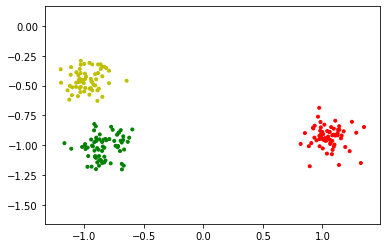

In [113]:
blah.Plot(idx=(0,1));

# Create Network

In [590]:
ds = SimpleDataset(A, B, n=50, noise=0.2)
dl = DataLoader(ds, batch_size=10, shuffle=True)

In [757]:
mid_dim = 6
net = PCNetwork.PCNetwork()
net.AddLayer(PCLayer.PCLayer(n=ds.input_dim))  # [0] v0 input

net.AddLayer(PCLayer.PCLayer(n=mid_dim+2))       # [1] e1 error
net.AddLayer(PCLayer.PCLayer(n=mid_dim))       # [2] v1 class

net.AddLayer(PCLayer.PCLayer(n=ds.n_classes+1))  # [3] e2 error
net.AddLayer(PCLayer.PCLayer(n=ds.n_classes))  # [4] v2 class

af0 = 'identity'
af = 'tanh'
sym = False
net.Connect(v_idx=0, e_idx=1, type='general', sym=sym, act_text=af0)
net.Connect(v_idx=2, e_idx=1, type='general', sym=False, act_text=af)
net.Connect(v_idx=2, e_idx=3, type='general', sym=sym, act_text=af)
net.Connect(v_idx=4, e_idx=3, type='general', sym=False, act_text=af)

net.SetTau(0.05)

# Training

In [742]:
#net.Plot(idx=0);

In [743]:
net.ClearHistory()
net.Probe(True)
net.Learning(True)
net.SetGamma(0.1)
mult = 1.

# Connection (v0)--(e1)
net.con[0].SetRandom(random=mult) # v0-e1
net.con[1].SetRandom(random=mult) # e1-v1
#net.con[1].SetIdentity()
net.con[2].SetRandom(random=mult) # v1-e2
net.con[3].SetRandom(random=mult) # e2-v2
#net.con[3].SetIdentity()

net.SetDynamicWeightDecay(0.01, 0.8)
net.SetActivityDecay(0.0)
net.SetBlackout(0.)

In [719]:
net.ClearHistory()
net.Probe(True)
net.Learning(True)
net.SetGamma(0.1)
mult = 1.
l = 0.
h = 1.


# Connection (v0)--(e1)
net.con[0].SetRandom(random=mult) # v0-e1
net.con[0].SetRandomUniform(low=l, high=h) # e1-v1
net.con[1].SetRandomUniform(low=l, high=h) # e1-v1
#net.con[1].SetIdentity()
net.con[2].SetRandom(random=mult) # v1-e2
net.con[3].SetRandomUniform(low=l, high=h) # e2-v2
#net.con[3].SetIdentity()

net.SetDynamicWeightDecay(0.01, 0.8)
net.SetRepelSmallWeights(0.0)
net.SetActivityDecay(0.0)
net.SetBlackout(0.)

In [758]:
net.ClearHistory()
net.Probe(True)
net.Learning(True)
net.SetGamma(0.1)
mult = 1.
l = 0.
h = 1.


# Connection (v0)--(e1)
net.con[0].SetRandomUniform(low=l, high=h) # e1-v1
net.con[1].SetRandomUniform(low=l, high=h) # e1-v1
#net.con[1].SetIdentity()
net.con[2].SetRandomUniform(low=l, high=h) # v1-e2
net.con[3].SetRandomUniform(low=l, high=h) # e2-v2
#net.con[3].SetIdentity()

net.SetDynamicWeightDecay(0.01, 0.8)
net.SetRepelSmallWeights(0.0)
net.SetActivityDecay(0.0)
net.SetBlackout(0.)

In [639]:
lc = 0.
#net.con[0].M.clamp_(lc, 100)
#net.con[0].W.clamp_(lc, 100)
net.con[1].M.clamp_(lc, 100)
net.con[1].W.clamp_(lc, 100)
#net.con[2].M.clamp_(lc, 100)
#net.con[2].W.clamp_(lc, 100)
net.con[3].M.clamp_(lc, 100)
net.con[3].W.clamp_(lc, 100)

tensor([[0.1087, 0.1910, 0.0000],
        [0.1188, 0.1485, 0.0000],
        [0.0194, 0.0021, 0.0131]])

In [759]:
net.ClearHistory()

In [760]:
print(net.con[0].M)
print(net.con[0].W.transpose(1,0))
print(net.con[1].M)
print(net.con[1].W.transpose(1,0))
print(net.con[2].M)
print(net.con[2].W.transpose(1,0))
print(net.con[3].M)
print(net.con[3].W.transpose(1,0))

tensor([[0.0269, 0.4610, 0.5429, 0.7840, 0.9486, 0.3643, 0.6014, 0.2203],
        [0.0380, 0.9438, 0.0963, 0.1994, 0.3035, 0.6579, 0.4613, 0.4421],
        [0.4366, 0.6525, 0.1807, 0.8142, 0.7470, 0.9786, 0.3880, 0.3407],
        [0.0057, 0.9861, 0.3510, 0.4470, 0.2323, 0.2088, 0.0162, 0.3808],
        [0.2723, 0.1701, 0.2343, 0.6972, 0.4260, 0.2350, 0.0960, 0.8536],
        [0.0867, 0.3495, 0.8389, 0.5185, 0.3281, 0.2175, 0.8292, 0.3158],
        [0.8129, 0.8518, 0.1769, 0.3042, 0.5287, 0.3803, 0.5477, 0.3566],
        [0.8543, 0.7768, 0.5017, 0.6093, 0.5923, 0.6993, 0.0858, 0.1965],
        [0.0802, 0.6481, 0.1118, 0.2255, 0.4450, 0.5652, 0.4120, 0.5237],
        [0.8037, 0.9565, 0.5787, 0.3649, 0.6680, 0.6824, 0.8720, 0.1189]])
tensor([[0.0946, 0.9588, 0.5784, 0.8459, 0.4230, 0.6829, 0.4766, 0.9021],
        [0.7820, 0.7441, 0.2957, 0.3764, 0.5313, 0.8333, 0.1001, 0.7672],
        [0.6089, 0.6232, 0.7274, 0.3668, 0.3586, 0.4864, 0.4446, 0.3201],
        [0.7925, 0.4432, 0.1222, 0.96

In [761]:
net.Learning(True)
net.con[0].Learning(False)
net.con[1].Learning(True)
net.con[2].Learning(False)
net.con[3].Learning(True)
net.SetDynamicWeightDecay(0.01, 0.8)
net.Learn(dl, T=3., epochs=2)

Epoch: 0 weight decay = 0.01
Epoch: 1 weight decay = 0.002


In [762]:
net.Learning(True)
net.con[0].Learning(True)
net.con[1].Learning(False)
net.con[2].Learning(True)
net.con[3].Learning(False)
net.SetDynamicWeightDecay(0.01, 0.8)
net.Learn(dl, T=3., epochs=2)

Epoch: 0 weight decay = 0.01
Epoch: 1 weight decay = 0.002


In [763]:
net.Learning(True)
net.con[0].Learning(False)
net.con[1].Learning(True)
net.con[2].Learning(False)
net.con[3].Learning(True)
net.SetDynamicWeightDecay(0.0, 0.8)
net.Learn(dl, T=3., epochs=2)

Epoch: 0 weight decay = 0.0
Epoch: 1 weight decay = 0.0


In [764]:
net.Learning(True)
net.con[0].Learning(True)
net.con[1].Learning(False)
net.con[2].Learning(True)
net.con[3].Learning(False)
net.SetDynamicWeightDecay(0.0, 0.8)
net.Learn(dl, T=3., epochs=2)

Epoch: 0 weight decay = 0.0
Epoch: 1 weight decay = 0.0


In [766]:
print(net.con[0].M)
print(net.con[0].W.transpose(1,0))
print(net.con[1].M)
print(net.con[1].W.transpose(1,0))
print(net.con[2].M)
print(net.con[2].W.transpose(1,0))
print(net.con[3].M)
print(net.con[3].W.transpose(1,0))

tensor([[-0.0264,  0.2112,  0.1106,  0.2394,  0.1933,  0.2092,  0.2339,  0.0871],
        [ 0.0821,  0.2337,  0.0253,  0.1303,  0.0917,  0.1501,  0.1762,  0.1607],
        [ 0.1601,  0.1574,  0.1022,  0.3242,  0.3063,  0.3169,  0.1897,  0.0769],
        [-0.0481,  0.2422,  0.1442,  0.0473,  0.0473,  0.0115,  0.0544,  0.1189],
        [ 0.0938,  0.1337,  0.0580,  0.0822,  0.0675,  0.0691,  0.0799,  0.1175],
        [ 0.0809,  0.1652,  0.0759,  0.1380,  0.1283,  0.1075,  0.0554,  0.1454],
        [ 0.2911,  0.2913,  0.0682,  0.0936,  0.1170,  0.1111,  0.0980,  0.2279],
        [ 0.1513,  0.1956,  0.1218,  0.2576,  0.2469,  0.2444,  0.1671,  0.0953],
        [-0.1990,  0.1860,  0.0905,  0.0982,  0.0289,  0.0393,  0.1333,  0.1144],
        [ 0.2702,  0.2892,  0.0763,  0.2067,  0.1946,  0.2296,  0.2394,  0.2191]])
tensor([[-0.0027,  0.3860,  0.1231,  0.2611,  0.0087,  0.3211,  0.1901,  0.3265],
        [ 0.3434,  0.1635,  0.0953,  0.1925,  0.1717,  0.2118,  0.0493,  0.2749],
        [ 0.220

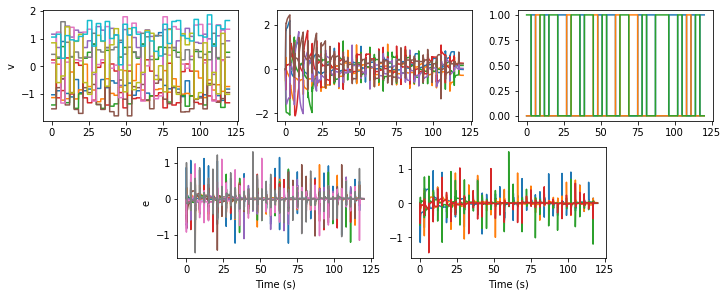

In [767]:
net.Plot(idx=0);

# Classification

In [771]:
net.Reset(random=1.)
net.SetActivityDecay( 0.0 )
y = net.Predict(ds.Inputs(), T=10.)
print(y[:10])
print(ds.Targets()[:10])

tensor([[ 0.0570,  0.9626, -0.0519],
        [ 0.7997, -0.0357, -0.1328],
        [-0.0067, -0.0840,  0.8972],
        [-0.0533,  0.9041, -0.0550],
        [ 0.0197, -0.0201,  0.9042],
        [ 0.0522,  0.8596, -0.0717],
        [ 0.8427, -0.0072,  0.0165],
        [-0.0376,  0.9986,  0.0747],
        [ 0.8748, -0.0858, -0.0532],
        [ 0.8185,  0.0449,  0.1270]])
tensor([[0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.]])


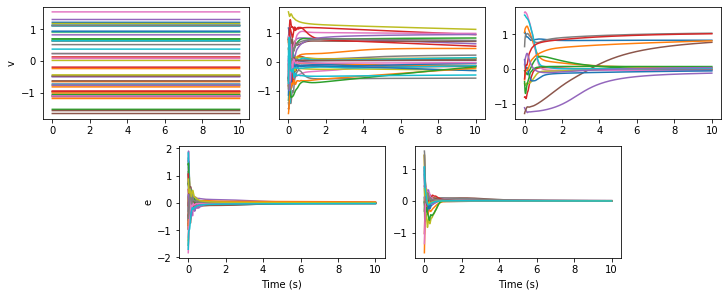

In [769]:
net.Plot(idx=[1,2,3,4,5]);

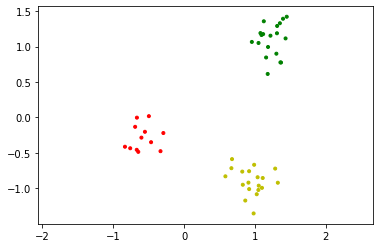

In [772]:
ds.Plot(labels=y, idx=(4,8))

# Generation

In [559]:
net.Reset(random=1.)
net.SetActivityDecay(0.02)
X = net.Generate(ds.Targets(), T=15.)

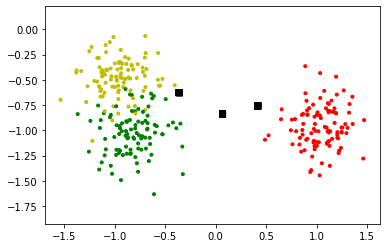

In [560]:
sidx = (0,1)
ds.Plot(idx=sidx)
plt.plot(X[:,sidx[0]], X[:,sidx[1]], 's', color=[0,0,0,0.1]);

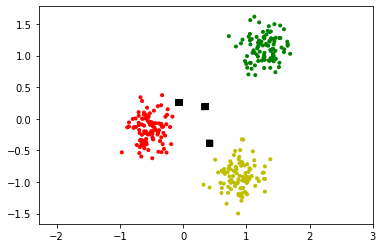

In [561]:
sidx = (4,8)
ds.Plot(idx=sidx)
plt.plot(X[:,sidx[0]], X[:,sidx[1]], 's', color=[0,0,0,0.1]);